In [ ]:
!pip install bs4

In [ ]:
!pip install requests

In [ ]:
from bs4 import BeautifulSoup
from urllib.request import urlopen

html = urlopen('https://novel.naver.com/webnovel/detail.nhn?novelId=765207&volumeNo=262')
src = html.read()
html.close()

soup = BeautifulSoup(src, 'lxml')
print(soup)

<!DOCTYPE html>
<html lang="ko">
<head>
<meta charset="utf-8"/>
<meta content="IE=edge" http-equiv="X-UA-Compatible"/>
<meta contents="always" name="referrer"/>
<title>262화. 행복, 재혼 황후 : 네이버웹소설</title>
<link href="https://ssl.pstatic.net/static/m/novel/icon_2020/favicon.ico" rel="shortcut icon" type="image/x-icon"/>
<link href="https://ssl.pstatic.net/static/novel/naverwebnovel_32x32.png" rel="icon" sizes="32x32"/>
<link href="/css/novel.css?1606724516000" rel="stylesheet" type="text/css"/>
<script src="/js/lib/jquery-3.5.1.min.js" type="text/javascript"></script>
<script>
	var jQuery = $.noConflict();
</script>
<script type="text/javascript">
document.domain = 'naver.com';


var gnb_service = "novel";
var gnb_logout = encodeURIComponent(location.href);
var gnb_template = "gnb_utf8";
var gnb_brightness = 1;


var ccsrv = 'cc.naver.com';
var nsc = "novel.nsc";
var nclk_evt = 3;


var lcs_SerName = 'lcs.naver.com';


var gRosYn = 'N';
var gRosAlertMessage = '정기점검중 입니다.';
</script>
<meta c

In [ ]:
content = soup.find(id='content')

In [ ]:
#print(content)
#print(soup.select_one('.detail_view_content').get_text())

In [ ]:
f = open('./재혼황후.txt', 'w')
f.write(soup.select_one('.detail_view_content').get_text())
f.close()

https://hogni.tistory.com/21


https://nwy1996.tistory.com/54


http://cedartrees.co.kr/index.php/2021/01/23/sequence2sequence-nlg/


https://wikidocs.net/24996

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np
import pandas as pd
import os
from argparse import Namespace
from collections import Counter

In [ ]:
config = Namespace(
    train_file='/content/재혼황후.txt', seq_size=7, batch_size=100,
)

In [ ]:
with open(config.train_file, 'r', encoding='utf-8') as f:
    text = f.read()
text = text.split()
print(text)

['“늘', '건강하시길.', '조만간', '좋은', '소식', '들고', '달려오겠습니다.”마스타스는', '내게', '인사를', '건넨', '뒤', '고개를', '돌려', '로라를', '보았다.', '마스타스와', '많이', '친해진', '로라는', '아침부터', '내내', '우느라', '얼굴이', '빨개져', '있었다.', '“로라.', '하나하나', '다', '물어봐서', '귀찮았을', '텐데.', '많이', '알려주고', '도와줘서', '고마워.”마스타스가', '로라를', '안고서', '인사했지만,', '로라는', '더', '펑펑', '울었다.', '대답조차', '하지', '못할', '정도로.', '대신', '로즈가', '옆에서', '눈시울을', '닦으며', '타박했다.', '“귀찮은', '질문에', '대답해준', '건', '나였어요,', '마스타스', '양.”마스타스는', '로라를', '놓고서', '로즈를', '보며', '활짝', '웃었다.', '“듣고', '보니', '그러네요,', '선배님.', '선배님한테도', '감사했습니다.”이윽고', '마스타스는', '주베르', '백작부인에게도', '부탁했다.', '“황후', '폐하의', '힘이', '되어주세요,', '백작부인.”주베르', '백작부인은', '한숨을', '내쉬었다.', '“그건', '당연한', '일이고.', '마스타스', '양은', '이왕', '이렇게', '간', '김에', '아주', '제대로', '전공을', '세우고', '돌아와요.”마스타스는', '호탕하게', '웃음을', '터트렸다.', '“당연합니다.', '그건', '쉽죠.”“코샤르', '경도', '꽉', '잡고.”덧붙인', '주베르', '백작부인의', '말에는', '얼굴이', '벌개졌지만.', '그래도', '부정하진', '않는구나,', '마스타스.', '“출발할', '시간입니다,', '마스타스', '경.”그러고', '있자니', '마스타스와', '비슷한', '디자인의', '제복을', '입은', '기사가', '다가와', '알렸다.', '당연하다

학습을 위해 중복 단어를 제거하고, word2index, index2word 형태의 데이터셋을 생성한다. 

이렇게 만들어진 데이터셋을 통해서 각 문장을 어절 단위로 분리하고 각 배열의 인덱스값을 맵핑해서 

문장을 숫자 형태의 값을 가진 데이터로 변경한다.

In [ ]:
word_counts = Counter(text)
sorted_vocab = sorted(word_counts, key=word_counts.get, reverse=True)
int_to_vocab = {k: w for k, w in enumerate(sorted_vocab)}
vocab_to_int = {w: k for k, w in int_to_vocab.items()}
n_vocab = len(int_to_vocab)

print('Vocab size', n_vocab)

int_text = [vocab_to_int[w] for w in text] # 전체 텍스트를 index로 변경

Vocab size 1271


학습을 위한 데이터를 만드는 과정

데이터는 source_word와 target_word로 분리한다.

source_word는 [‘In’, ‘the’, ‘beginning,’, ‘God’, ‘created’, ‘the’, ‘heavens’],

target_word는 [ ‘the’, ‘beginning,’, ‘God’, ‘created’, ‘the’, ‘heavens’,’and’] 형태이다.

즉, source_word 문장 배열 다음에 target_word가 순서대로 등장한다는 것을 모델이 학습하도록 한다.

여기서 문장의 크기는 7로 정한다. 더 큰 사이즈로 학습을 진행하면 문장을 생성할 때 더 좋은 예측을 할 수 있으나, 

계산량이 많아져서 학습 시간이 많이 필요하다.



In [ ]:
source_words = []
target_words = []
for i in range(len(int_text)):
    ss_idx, se_idx, ts_idx, te_idx = i, (config.seq_size+i), i+1, (config.seq_size+i)+1
    if len(int_text[ts_idx:te_idx]) >= config.seq_size:
        source_words.append(int_text[ss_idx:se_idx])
        target_words.append(int_text[ts_idx:te_idx])

In [ ]:
for s,t in zip(source_words[0:10], target_words[0:10]):
    print('source {} -> target {}'.format(s,t))

source [253, 254, 255, 26, 256, 257, 258] -> target [254, 255, 26, 256, 257, 258, 259]
source [254, 255, 26, 256, 257, 258, 259] -> target [255, 26, 256, 257, 258, 259, 260]
source [255, 26, 256, 257, 258, 259, 260] -> target [26, 256, 257, 258, 259, 260, 261]
source [26, 256, 257, 258, 259, 260, 261] -> target [256, 257, 258, 259, 260, 261, 262]
source [256, 257, 258, 259, 260, 261, 262] -> target [257, 258, 259, 260, 261, 262, 7]
source [257, 258, 259, 260, 261, 262, 7] -> target [258, 259, 260, 261, 262, 7, 92]
source [258, 259, 260, 261, 262, 7, 92] -> target [259, 260, 261, 262, 7, 92, 48]
source [259, 260, 261, 262, 7, 92, 48] -> target [260, 261, 262, 7, 92, 48, 49]
source [260, 261, 262, 7, 92, 48, 49] -> target [261, 262, 7, 92, 48, 49, 93]
source [261, 262, 7, 92, 48, 49, 93] -> target [262, 7, 92, 48, 49, 93, 94]


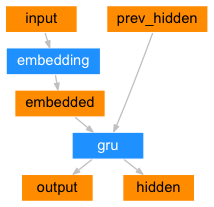

아래는 Encoder의 구조이다. Encoder는 두 개의 값이 GRU Cell로 들어가게 된다. 

하나는 입력 값이 Embedding layer를 통해서 나오는 값과 또 하나는 이전 단계의 Hidden 값이다. 

최종 Hidden 값은 입력된 문장의 전체 정보를 어떤 고정된 크기의 Context Vector에 축약하고 있기 때문에 

이 값을 Decoder의 입력으로 사용한다. 

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size) #199->10
        self.gru = nn.GRU(hidden_size, hidden_size) #20-20

    def forward(self, x, hidden):
        x = self.embedding(x).view(1,1,-1)
        x, hidden = self.gru(x, hidden)
        return x, hidden

아래 그림과 같이 Decoder를 설계. Decoder 역시 GRU cell을 가지고 있다.

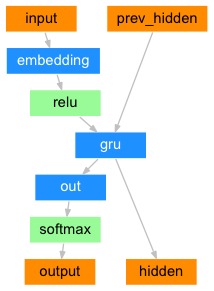

In [ ]:
class Decoder(nn.Module):
    def __init__(self, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(output_size, hidden_size) #199->10
        self.gru = nn.GRU(hidden_size, hidden_size) #10->10
        self.out = nn.Linear(hidden_size, output_size) #10->199
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, x, hidden):
        x = self.embedding(x).view(1,1,-1)
        x, hidden = self.gru(x, hidden)
        x = self.softmax(self.out(x[0]))
        return x, hidden

In [ ]:
enc_hidden_size = 50
dec_hidden_size = enc_hidden_size
encoder = Encoder(n_vocab, enc_hidden_size) # source(199) -> embedding(10)
decoder = Decoder(dec_hidden_size, n_vocab) # embedding(199) -> target(199)
encoder_optimizer = optim.SGD(encoder.parameters(), lr=0.01)
decoder_optimizer = optim.SGD(decoder.parameters(), lr=0.01)
criterion = nn.NLLLoss()

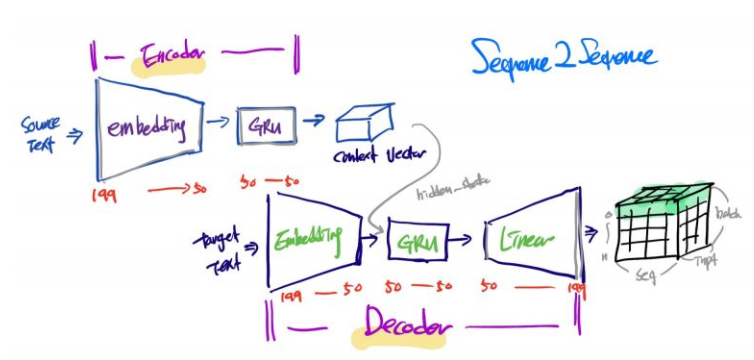

Encoder

    (embedding): Embedding(199, 50)
    (gru): GRU(50, 50)




Decoder

    (embedding): Embedding(199, 50)
    (gru): GRU(50, 50)
    (out): Linear(in_features=50, out_features=199, bias=True)
    (softmax): LogSoftmax(dim=1)




데이터를 100개씩 나눠서 훈련할 수 있도록 배치 모델을 작성.


In [ ]:
pairs = list(zip(source_words, target_words))
def get_batch(pairs, batch_size):
  pairs_length = len(pairs)
  for ndx in range(0, pairs_length, batch_size):
    #print(ndx, min(ndx+batch_size, pairs_length))
    yield pairs[ndx:min(ndx+batch_size, pairs_length)]

500번 학습을 수행. 각 batch, epoch 마다 loss 표시.

In [ ]:
number_of_epochs = 501
for epoch in range(number_of_epochs):
    total_loss = 0
    #for pair in get_batch(pairs, config.batch_size): # batch_size 100
    for pair in get_batch(pairs, 100): # batch_size 100
      batch_loss = 0
       
      for si, ti in pair:
        x = torch.Tensor(np.array([si])).long().view(-1,1)
        y = torch.Tensor(np.array([ti])).long().view(-1,1)
        encoder_hidden = torch.zeros(1,1,enc_hidden_size)
        for j in range(config.seq_size):
            _, encoder_hidden = encoder(x[j], encoder_hidden)
        decoder_hidden = encoder_hidden
        decoder_input = torch.Tensor([[0]]).long()
        loss = 0
        for k in range(config.seq_size):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            decoder_input = y[k]
            loss += criterion(decoder_output, y[k])
        batch_loss += loss.item()/config.seq_size
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()
        loss.backward()
        encoder_optimizer.step()
        decoder_optimizer.step()
      total_loss += batch_loss/config.batch_size
      #print('batch_loss {:.5f}'.format(batch_loss/config.batch_size))
    print('epoch {}, loss {:.10f}'.format(epoch, total_loss/(len(pairs)//config.batch_size)))

epoch 0, loss 6.9578081855
epoch 1, loss 6.0737726473
epoch 2, loss 4.9556969984
epoch 3, loss 3.8245909366
epoch 4, loss 2.8558051189
epoch 5, loss 2.1465853863
epoch 6, loss 1.6936744205
epoch 7, loss 1.4208707247
epoch 8, loss 1.2432127184
epoch 9, loss 1.1149544108
epoch 10, loss 1.0149078488
epoch 11, loss 0.9299419302
epoch 12, loss 0.8551524105
epoch 13, loss 0.7888964213
epoch 14, loss 0.7301608881
epoch 15, loss 0.6743863253


In [ ]:
torch.save({
  'encoder': encoder.state_dict(), 'decoder':decoder.state_dict(),
  'config': config,
}, '/content/drive/MyDrive/대학원/2학기/빅데이터딥러닝/과제3/model.210524')

학습이 완료된 후에 해당 모델이 잘 학습되었는지,

"darkness was"라는 몇가지 단어를 주고 모델이 어떤 문장을 생성하는지를 알아보는 방식으로 수행.



In [ ]:
decoded_words = []
words = [vocab_to_int['고개를'], vocab_to_int['돌리자']]
x = torch.Tensor(words).long().view(-1,1).to(device)
encoder_hidden = torch.zeros(1,1,enc_hidden_size).to(device)
for j in range(x.size(0)):
    _, encoder_hidden = encoder(x[j], encoder_hidden)
decoder_hidden = encoder_hidden
decoder_input = torch.Tensor([[words[1]]]).long().to(device)  
for di in range(20):
  decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
  _, top_index = decoder_output.data.topk(1)
  decoded_words.append(int_to_vocab[top_index.item()])
  decoder_input = top_index.squeeze().detach()
predict_words = decoded_words    
predict_sentence = ' '.join(predict_words)
print(predict_sentence)